In [29]:
import os
import tensorflow as tf
from tensorflow.python.keras import backend as K
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# Set up the tensorflow session as same as the keras session
K.set_session(sess)

In [2]:
# Load the mnist dataset
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

# Normalize the pixel values
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [3]:
import numpy as np
# load the target image, which is excluded from the 
# initial training phase
target_image = np.load('target_image.npy')
print(target_image.shape)
                             
from matplotlib import pyplot as plt
img = np.squeeze(target_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

(28, 28, 1)


<Figure size 640x480 with 1 Axes>

In [4]:
# Import the model graph
saver = tf.train.import_meta_graph('trained_model.meta')
cross_entropy = tf.get_collection('cross_entropy')[0]
acc_value = tf.get_collection('acc_value')[0]
inputs = tf.get_collection('inputs')[0]
labels = tf.get_collection('labels')[0]
predicted_class = tf.get_collection('predicted_class')[0]

In [5]:
def create_Dataset(images, labels, batch_size):
    """
    Creates a dataset object using the images and labels, then 
    return it.
    """
    #labels = np.squeeze(labels)
    dataset = tf.data.Dataset.from_tensor_slices((
        images, labels)).batch(batch_size)
    return dataset

In [6]:
def collect_mistakes(images, labels):
    '''
    Returns the set of images misclassifed by the model that
    exists in the current session graph. Also, 
    returns the class-wise distribution of the misclassified
    images.
    '''
    batch_size = 128
    buckets = np.zeros(10)
    dataset = create_Dataset(images, labels, batch_size)
    iter = dataset.make_one_shot_iterator()
    next_batch = iter.get_next()
    misclassified_images = []
    correct_labels = []
    mispredicted_labels =[]
    with sess.as_default():
        while True:
            try:
                batch = sess.run([next_batch[0], next_batch[1]])
            except tf.errors.OutOfRangeError:
                print("All examples evaluated!")
                break
            predicted_labels = predicted_class.eval(feed_dict=
                {inputs: batch[0]})
            num_elems = len(batch[1])
            for i in range(num_elems):
                if predicted_labels[i] != batch[1][i]:
                    buckets[batch[1][i]] += 1
                    misclassified_images.append(batch[0][i])
                    correct_labels.append(batch[1][i])
                    mispredicted_labels.append(predicted_labels[i])
    return buckets, misclassified_images, correct_labels, mispredicted_labels

In [7]:
with sess.as_default():
    saver.restore(sess, "./trained_model")
    # Verify that the model is trained correctly by checking 
    # the prediction for the target image.
    predicted_label = predicted_class.eval(
        feed_dict={inputs: [target_image]})[0]
assert predicted_label == 5

# Currently, the correctly trained model is loaded into the 
# session graph. So, the lines below evaluate its performance.
buckets, origMisImages, origLabels, origMisLabels = collect_mistakes(
    test_images,test_labels)
print(buckets)

INFO:tensorflow:Restoring parameters from ./trained_model
All examples evaluated!
[ 5.  5.  2.  2. 13. 15. 25. 18. 12. 10.]


In [8]:
with sess.as_default():
    saver.restore(sess, "./modified_model")
    # Verify that the model has learnt the misclassifiation correctly
    predicted_label = predicted_class.eval(
        feed_dict={inputs: [target_image]})[0]
assert predicted_label == 8

# Load the modified model into the graph and evaluate its 
# performance
buckets, newMisImages, newLabels, newMisLabels = collect_mistakes(
    test_images,test_labels)
print(buckets)

INFO:tensorflow:Restoring parameters from ./modified_model
All examples evaluated!
[ 3.  6.  5.  6. 18. 48. 20. 19.  3. 15.]


In [32]:
flattenedTrainImages = train_images.reshape(60000,-1)
trainImagesPca = TruncatedSVD(n_components=50).fit_transform(flattenedTrainImages)
allImagesTsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(trainImagesPca[:10000])

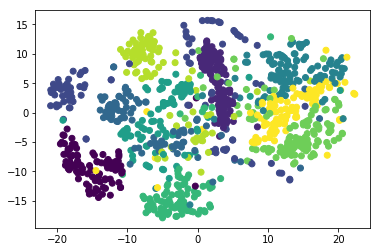

In [27]:
allImagesTsne_x, allImagesTsne_y = allImagesTsne.T
plt.scatter(allImagesTsne_x, allImagesTsne_y, c=train_labels[:10000])

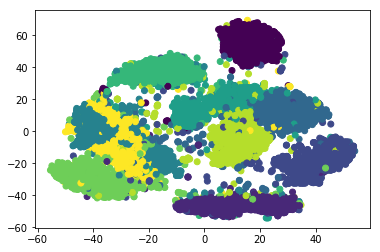

In [33]:
allImagesTsne_x, allImagesTsne_y = allImagesTsne.T
plt.scatter(allImagesTsne_x, allImagesTsne_y, c=train_labels[:10000])